<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/part-2/Neural_network_face_classificaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Часть 2**
***Решение задачи классификации с использованием нейронных сетей.***

In [75]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
from google.colab import drive
from sklearn.externals import joblib 
from PIL import Image, ImageDraw

# подключение гугл-диска
drive.mount('/content/drive')

PATH = '/content/drive/My Drive/Курсач/files/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
#Загрузим всё необходимое
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.optim as optim
import time

all_features = joblib.load(os.path.join(PATH,'all_features.pkl'))
y_train = joblib.load(os.path.join(PATH,'y_train.pkl'))
y_test = joblib.load(os.path.join(PATH,'y_test.pkl'))
time_of_features_creat = joblib.load(os.path.join(PATH,'time_of_features_creat.pkl'))

features_list = ['Haars features', 'Matrix features','Matrix + PCA features']
categories = ['hf_train', 'mf_train','pca_train', 'hf_test', 'mf_test', 'pca_test']
net_cols = ['fully_con_net_cpu', 'fully_con_net_gpu','convol_net_cpu', 'convol_net_gpu']

net_time_df = pd.DataFrame(index = categories, columns = net_cols)
net_accuracy = pd.DataFrame(features_list, index=['1', '2', '3'], columns=['features'])

In [77]:
#сразу приплюсуем время на создание самих признаков

for i, rows in enumerate(categories):
    net_time_df.loc[rows] = time_of_features_creat[i]

print('Time for feature creating')
net_time_df[:]

Time for feature creating


,fully_con_net_cpu,fully_con_net_gpu,convol_net_cpu,convol_net_gpu
hf_train,0.00151171,0.00151171,0.00151171,0.00151171
mf_train,1.07321e-05,1.07321e-05,1.07321e-05,1.07321e-05
pca_train,1.05842e-05,1.05842e-05,1.05842e-05,1.05842e-05
hf_test,0.00150814,0.00150814,0.00150814,0.00150814
mf_test,1.0517e-05,1.0517e-05,1.0517e-05,1.0517e-05
pca_test,1.07233e-05,1.07233e-05,1.07233e-05,1.07233e-05


#Полносвязная нейронная сеть

Во 2 части предметом исследования станут нейронные сети. А именно мы хотим провести сравнительный анализ для методов машинного обучения и нейронных сетей в задаче классификации лиц на изображении. Для этого возьмём все типы признаков из предыдущей части, а критериями сравнения станут точность, время обучения и предсказания, а также объём занимаемой памяти обученных моделей.

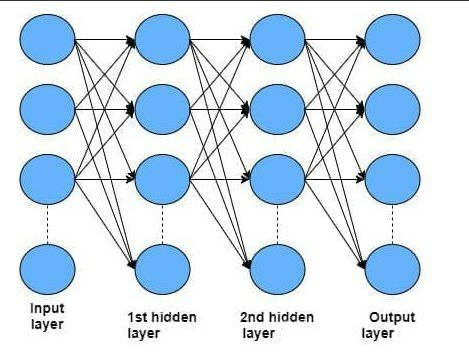  

Для построения архитектуры сети, нам необходимо определить количество слоёв и нейронов, а также задать функцию потерь, оптимизационную функцию и тд... Подбор параметров осуществим эмпирическим путём.  
  
   
**P.S. Построенную полносвязную сеть будем описывать как `a / x_1 / ... / x_n / b`, где `a`, `b` - число нейронов входного слоя и выходного слоя, а `x_i` - число нейронов скрытых слоёв. Результаты экспериментов при построении архитектур можно найти здесь: https://docs.google.com/spreadsheets/d/1Qvn6k-yyfEuRum9eUxRetVPQpU6imFPau3qaQrLEOYc/edit?usp=sharing**  
  
  
Проведём эксперименты для полносвязной сети со следующими параметрами:



> Схема сети: `len(features)/70/35/2 `    
> Функция активации: `sigmoid  `  
> Функция потерь: `CrossEntropyLoss`  
> Оптимизационная функция: `Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)`




In [78]:
class Net(nn.Module):
    def __init__(self, input_len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_len, 70)
        self.fc2 = nn.Linear(70, 35)
        self.fc3 = nn.Linear(35, 2)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))
        return out

#Свёрточная нейронная сеть
пометки, чтобы не забыть, что из себя представляет 1 объект выборки: 


1.   Признаки Хоара - вектор 1*109
2.   Матрица - вектор 1*625
3.   Матрица + pca - вектор 1*109  

Число каналов - 1.





In [ ]:
import math

class ConvNet(nn.Module): 
    def __init__(self, input_len): 
         super(ConvNet, self).__init__() 
         self.layer1 = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=(3 - input_len % 3)), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=3)) 
         self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 1), stride=1, padding=(3 - input_len % 3, 1)), 
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=3)) 
         self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 1), stride=1, padding=(3 - input_len % 3, 1)),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=3)) 
         #self.drop_out = nn.Dropout() 
         self.fc1 = nn.Linear(in_features=1 * math.ceil(input_len / 9) * 64, out_features=64)
         self.fc2 = nn.Linear(in_features=64, out_features=32)
         self.fc3 = nn.Linear(in_features=32, out_features=16)
         self.fc4 = nn.Linear(in_features=16, out_features=2)
    
    def forward(self, x):
         out = self.layer1(x) 
         out = self.layer2(out) 
         out = self.layer3(out) 
         out = self.drop_out(out) 
         out = out.view(out.size(0), -1)
         out = F.relu(self.fc1(out))
         out = F.relu(self.fc2(out))
         out = F.relu(self.fc3(out))
         out = F.sigmoid(self.fc4(out))
         return out

#Обучение и предсказание
(*текст*)

In [79]:
def plot_graphic(y_points, title):
    x_points = lambda x: np.arange(0,len(y_points[x]))

    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=18, fontname='Times New Roman')
    plt.xlabel('Epoch',fontsize=16, fontname='Times New Roman')
    plt.ylabel('Score',fontsize=16, fontname='Times New Roman')
    plt.plot(x_points(0), y_points[0], color='#fb607f', linestyle='-')
    plt.plot(x_points(1), y_points[1], color='#906bff', linestyle='-')
    plt.plot(x_points(2), y_points[2], color='#c71585', linestyle='-')
    plt.legend(features_list, loc='center', shadow=True,fontsize=18)
    plt.show()

In [80]:
def nn_training(x_train, y_train, is_gpu, loop, time_df, feature_type, index,
                y_points_acc, y_points_loss, net_type):
    
    if (net_type == 'convolution'):
        net = ConvNet(len(x_train[0]))
        net_index = 1
    else:
        net = Net(len(x_train[0]))
        net_index = 0

    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    #сделаем массивы точек для построения гафиков accuracy при обучении
    y_points_for_one = []
    y_loss_points_for_one = []

    t0 = time.time()
    x_train_torch = torch.from_numpy(x_train).float()
    y_train_torch = torch.from_numpy(y_train)

    #будем проверять на 2-х процессорах
    if is_gpu == 1:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")
    net.to(device)
    x_train_torch, y_train_torch = x_train_torch.to(device), y_train_torch.to(device)
    print(device)

    for epoch in range(loop): # loop

        optimizer.zero_grad()
        output = net(x_train_torch)
        loss = criterion(output, y_train_torch)
        loss.backward()
        optimizer.step()


        y_loss_points_for_one.append(loss.item())
        y_points_for_one.append(accuracy_score(y_train, torch.argmax(output.data, dim = 1 ).cpu()))
        if len(y_points_for_one) >=100 and np.all(y_points_for_one[-100:] == y_points_for_one[-1]):
            print('Train is stopped, no changes in last 100 epoch! Epoch: ', epoch)
            break
    t = time.time()
    print('Last accuracy: ', y_points_for_one[-1])

    #сохраним обученную сеть        
    torch.save(net.state_dict(), os.path.join(PATH, 'Networks', feature_type + '_' + net_type + '_neural_net.pth'))

    #заполним табличку с временем
    time_df.loc[categories[index]][net_cols[is_gpu + 2 * net_index]] += (t - t0)

    #нарисуем график 
    if (is_gpu == 1):
        y_points_acc.append(y_points_for_one)
        y_points_loss.append(y_loss_points_for_one)
        if (len(y_points_acc) == 3):
            print(net_type, ' network')
            plot_graphic(y_points_acc, 'Accuracy score')
            plot_graphic(y_points_loss, 'Loss')

In [81]:
def nn_test(x_test, is_gpu, feature_type, data_df, time_df, index, net_type):

    if (net_type == 'convolution'):
        net = ConvNet(len(x_test[0]))
        net_index = 1
    else:
        net = Net(len(x_test[0]))
        net_index = 0
    net.load_state_dict(torch.load(os.path.join(PATH, 'Networks', feature_type + '_' + net_type + '_neural_net.pth')))

    t0 = time.time()
    x_test_torch = torch.from_numpy(x_test).float()

    with torch.no_grad():
        output = net(x_test_torch)
        data_df[net_cols[is_gpu + 2 * net_index]] = torch.argmax(output.data, dim = 1)
    t = time.time()

    time_df.loc[categories[index]][net_cols[is_gpu + 2 * net_index]] += (t - t0)/len(x_test)

#Запуск

cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train is stopped, no changes in last 100 epoch! Epoch:  3479
Last accuracy:  0.9032987214805397
cuda:0
Train is stopped, no changes in last 100 epoch! Epoch:  6375
Last accuracy:  0.9162251889524616
cuda:0
Train is stopped, no changes in last 100 epoch! Epoch:  2309
Last accuracy:  0.9395175531539168
fully_connected  network


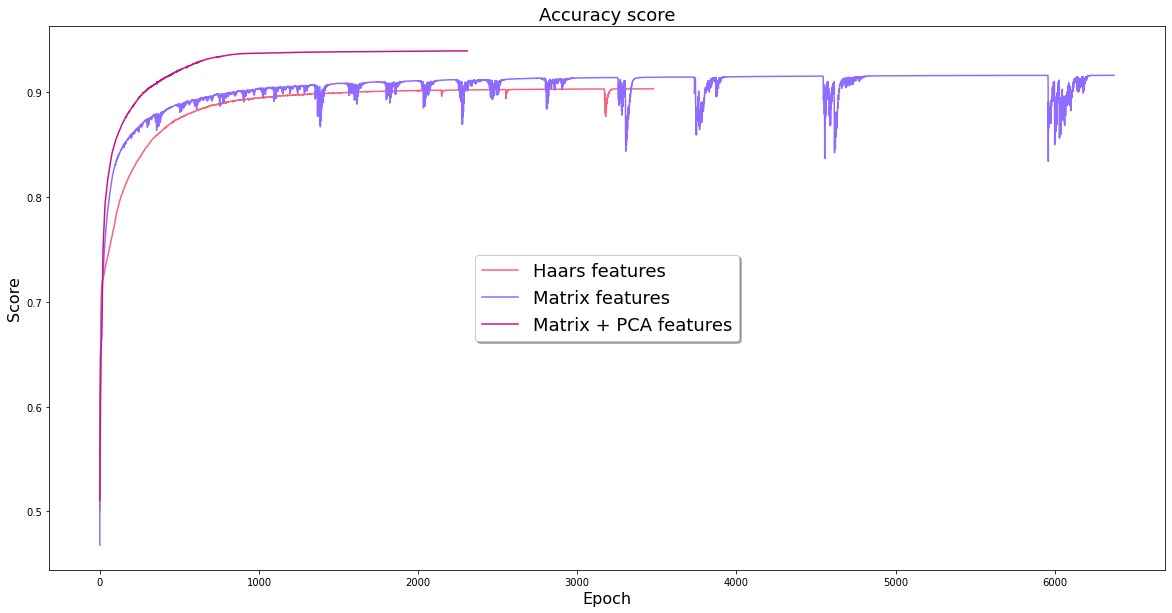

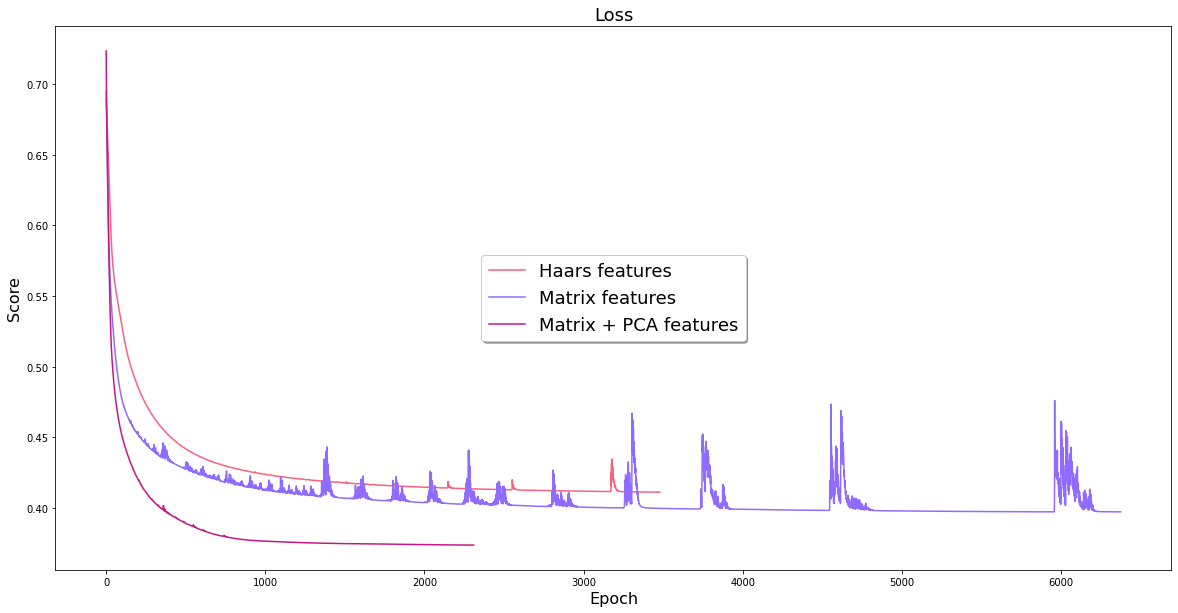

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [82]:
haars_net_df = pd.DataFrame(columns=net_cols)
matrix_net_df = pd.DataFrame(columns=net_cols)
matrix_net_pca_df = pd.DataFrame(columns=net_cols)
y_points_acc = []
y_points_loss = []
#networks = ['fully_connected', 'convolution']
networks = ['fully_connected']

MAX_ITER = 50000

for net_types in networks:
    for is_gpu in range(1,2):
        nn_training(all_features[0], y_train, is_gpu, MAX_ITER, net_time_df, 'hf', 0, y_points_acc, y_points_loss, net_types)
        nn_test(all_features[3], is_gpu, 'hf', haars_net_df, net_time_df, 3, net_types)

        nn_training(all_features[1], y_train, is_gpu, MAX_ITER, net_time_df, 'mf', 1, y_points_acc, y_points_loss, net_types)
        nn_test(all_features[4], is_gpu, 'mf', matrix_net_df, net_time_df, 4, net_types) 

        nn_training(all_features[2], y_train, is_gpu, MAX_ITER, net_time_df, 'mf_pca', 2, y_points_acc, y_points_loss, net_types)
        nn_test(all_features[5], is_gpu, 'mf_pca', matrix_net_pca_df, net_time_df, 5, net_types)
    
haars_net_df.insert(0, 'y_test', y_test)
matrix_net_df.insert(0, 'y_test', y_test)
matrix_net_pca_df.insert(0, 'y_test', y_test)


In [83]:
haars_net_df[:]

,y_test,fully_con_net_cpu,fully_con_net_gpu,convol_net_cpu,convol_net_gpu
0,1,NaN,1,NaN,NaN
1,0,NaN,0,NaN,NaN
2,0,NaN,0,NaN,NaN
3,0,NaN,0,NaN,NaN
4,0,NaN,1,NaN,NaN
...,...,...,...,...,...
18871,1,NaN,1,NaN,NaN
18872,0,NaN,0,NaN,NaN
18873,1,NaN,0,NaN,NaN
18874,0,NaN,0,NaN,NaN


In [84]:
net_time_df[:]

,fully_con_net_cpu,fully_con_net_gpu,convol_net_cpu,convol_net_gpu
hf_train,0.00151171,31.8216,0.00151171,0.00151171
mf_train,1.07321e-05,70.7828,1.07321e-05,1.07321e-05
pca_train,1.05842e-05,20.8658,1.05842e-05,1.05842e-05
hf_test,0.00150814,0.00151443,0.00150814,0.00150814
mf_test,1.0517e-05,1.5172e-05,1.0517e-05,1.0517e-05
pca_test,1.07233e-05,1.31852e-05,1.07233e-05,1.07233e-05


In [ ]:
#coxpaним датафреймы
haars_net_df.to_csv(os.path.join(PATH, 'Dataframes', 'haars_net_df.csv'))
matrix_net_df.to_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_df.csv'))
matrix_net_pca_df.to_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_pca_df.csv'))
net_time_df.to_csv(os.path.join(PATH, 'Dataframes', 'net_time_df.csv'))

#Анализ результатов

In [85]:
from pandas import read_csv

haars_net_df = read_csv(os.path.join(PATH, 'Dataframes', 'haars_net_df.csv')) 
matrix_net_df = read_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_df.csv')) 
matrix_net_pca_df = read_csv(os.path.join(PATH, 'Dataframes', 'matrix_net_pca_df.csv')) 
net_time_df = read_csv(os.path.join(PATH, 'Dataframes', 'net_time_df.csv')) 

#на данный момент здесь (1,2,2), тк работает только 1 сеть,
#но в перспективе это будет выглядеть вот так
for i in range(1,4,2):
    net_accuracy[net_cols[i]] = [accuracy_score(haars_net_df['y_test'], haars_net_df[net_cols[i]]),
                                    accuracy_score(matrix_net_df['y_test'], matrix_net_df[net_cols[i]]),
                                    accuracy_score(matrix_net_pca_df['y_test'], matrix_net_pca_df[net_cols[i]])]

net_accuracy[:]

,features,fully_con_net_gpu
1,Haars features,0.820619
2,Matrix features,0.831638
3,Matrix + PCA features,0.821360


In [ ]:
net = ConvNet(len(all_features[0][0]))
print(net)
print(len(all_features[0][0]))

ConvNet(
  (layer1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(1, 1), padding=(2, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 1), stride=(1, 1), padding=(2, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=832, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)
109


In [106]:
new_f = all_features[0].reshape(len(all_features[0]),len(all_features[0][0]),1,1)
print (len(new_f[0][0][0]))
new_f = torch.from_numpy(new_f).float()
net = ConvNet(109)

1


In [108]:

optimizer.zero_grad()
output = net(new_f[0])
print(output)


RuntimeError: ignored